In [17]:
from sklearn.ensemble import IsolationForest 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import VarianceThreshold

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
X = np.loadtxt('X_train.txt')
print(f'Размерность признаков {X.shape}')
print(f'Первые пять строчек {X[:5]}')

Размерность признаков (7352, 561)
Первые пять строчек [[ 0.28858451 -0.02029417 -0.13290514 ... -0.84124676  0.17994061
  -0.05862692]
 [ 0.27841883 -0.01641057 -0.12352019 ... -0.8447876   0.18028889
  -0.05431672]
 [ 0.27965306 -0.01946716 -0.11346169 ... -0.84893347  0.18063731
  -0.04911782]
 [ 0.27917394 -0.02620065 -0.12328257 ... -0.84864938  0.18193476
  -0.04766318]
 [ 0.27662877 -0.01656965 -0.11536185 ... -0.84786525  0.18515116
  -0.04389225]]


In [4]:
for i in range(20):
    print(f'Признак {i+1}: min={X[:, i].min()}, max={X[:, i].max()}')

Признак 1: min=-1.0, max=1.0
Признак 2: min=-1.0, max=1.0
Признак 3: min=-1.0, max=1.0
Признак 4: min=-1.0, max=1.0
Признак 5: min=-0.99987292, max=0.91623796
Признак 6: min=-1.0, max=1.0
Признак 7: min=-1.0, max=1.0
Признак 8: min=-1.0, max=0.96766404
Признак 9: min=-1.0, max=1.0
Признак 10: min=-1.0, max=1.0
Признак 11: min=-1.0, max=1.0
Признак 12: min=-1.0, max=1.0
Признак 13: min=-1.0, max=1.0
Признак 14: min=-1.0, max=1.0
Признак 15: min=-1.0, max=1.0
Признак 16: min=-1.0, max=1.0
Признак 17: min=-1.0, max=1.0
Признак 18: min=-0.9999986, max=1.0
Признак 19: min=-1.0, max=1.0
Признак 20: min=-1.0, max=1.0


In [6]:
X.std(axis=0)[:10]

array([0.07025655, 0.04080775, 0.05663134, 0.44870387, 0.50261047,
       0.41865824, 0.42404382, 0.48590857, 0.41409363, 0.54450954])

Хотя минимумы и максимумы не показали выбросы, стандартные отклонения различаются, где-то в районе десятых долей, где-то в районе сотых долей

In [7]:
np.isnan(X).sum()

np.int64(0)

Пропусков нет

Далее нужно удалить низковариативные признаки, но не более 10%(где-то 56 признаков), сейчас буду подбирать порог, чтобы удалить ~10% признаков

In [15]:
for t in [0.001, 0.01, 0.05, 0.02, 0.014]:
    X_reduced = VarianceThreshold(threshold=t).fit_transform(X)
    print(f'Порог={t}, осталось признаков = {X_reduced.shape[1]}')

Порог=0.001, осталось признаков = 561
Порог=0.01, осталось признаков = 524
Порог=0.05, осталось признаков = 369
Порог=0.02, осталось признаков = 474
Порог=0.014, осталось признаков = 506


При threshold=0.014, удалилось 55 признаков - отлично

In [16]:
X_reduced =  VarianceThreshold(threshold=0.014).fit_transform(X)

In [25]:
X_norm = StandardScaler().fit_transform(X_reduced)

pca = PCA().fit(X_norm)
rations = pca.explained_variance_ratio_
rations[:10]

array([0.52993923, 0.06457556, 0.0264536 , 0.02589703, 0.01918526,
       0.01687221, 0.0134871 , 0.01230077, 0.01016601, 0.00896116])

Смотрю первые 10 компонент, после 4 компонента explained_variance_ratio_ особо не меняется, но мне нужна дисперсия не ниже 90%

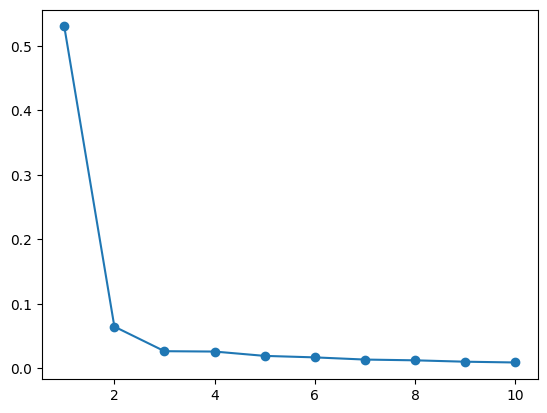

In [ ]:
plt.plot(range(1, 11), rations[:10], marker='o')

Оптимальное число компонентов по графику - 3, но опять же, дисперсия намного меньше 90%

In [32]:
cumsum = np.cumsum(rations)
n_components = np.argmax(cumsum >= 0.90) + 1
n_components

np.int64(56)

56 компонент объясняют 90% дисперсии

In [33]:
pca = PCA(n_components=56).fit(X_norm)
feature_pca = pca.transform(X_norm)

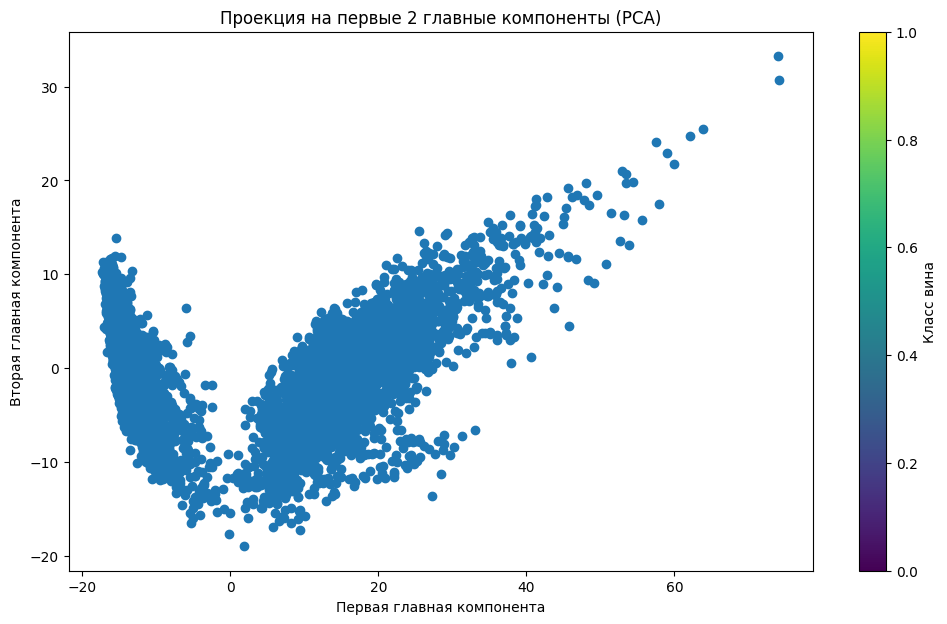

In [35]:
plt.figure(figsize=(12, 7))

plt.scatter(feature_pca[:, 0], feature_pca[:, 1])
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция на первые 2 главные компоненты (PCA)")
plt.colorbar(label="Класс вина")
plt.show()

Можно увидеть на графике две "кучки", которые хорошо различимы

In [36]:
distortion = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=12)
    model.fit(X_norm)
    distortion.append(model.inertia_)

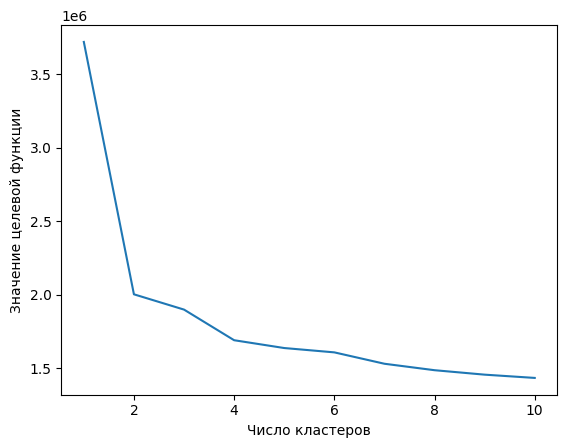

In [37]:
plt.Figure(figsize=(7, 6))
plt.plot(range(1, 11), distortion)
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show()

Оптимально число кластеров - 4, так как до значение 4 значение inertia_ резко падает, а после 4 - более гладко и сильно не меняется

In [43]:
model = KMeans(n_clusters=4, random_state=12)
model.fit(X_norm)

,n_clusters,4
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,12
,copy_x,True
,algorithm,'lloyd'


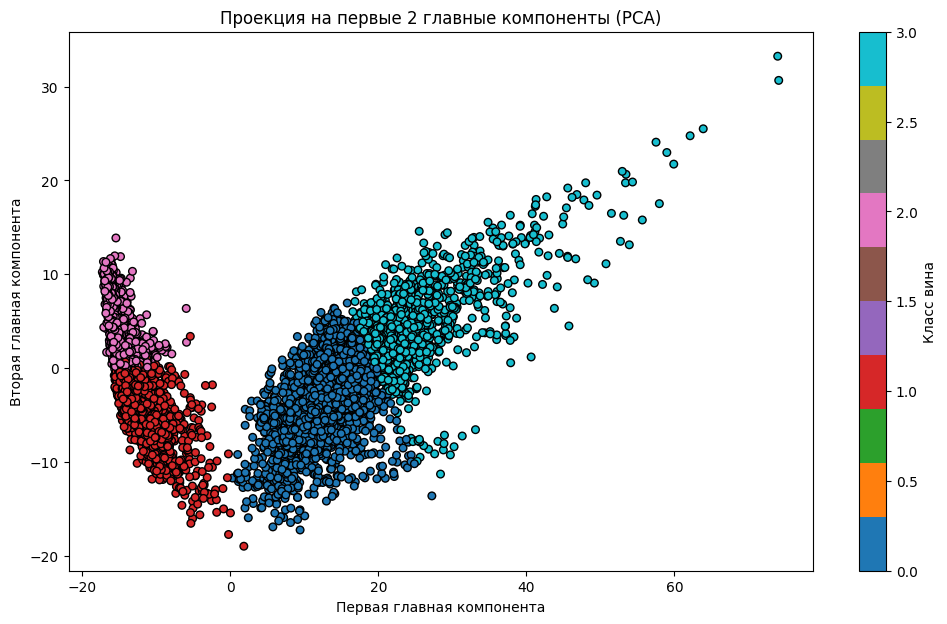

In [44]:
plt.figure(figsize=(12, 7))

plt.scatter(feature_pca[:, 0], feature_pca[:, 1], c=model.labels_, cmap='tab10', s=30, edgecolors='k')
plt.xlabel("Первая главная компонента")
plt.ylabel("Вторая главная компонента")
plt.title("Проекция на первые 2 главные компоненты (PCA)")
plt.colorbar(label="Класс вина")
plt.show()

In [47]:
y = np.loadtxt('y_train.txt')
print(f'Форма y: {y.shape}')
print(f'Первые 10 меток: {y[:10]}')


Форма y: (7352,)
Первые 10 меток: [5. 5. 5. 5. 5. 5. 5. 5. 5. 5.]


In [50]:
table = pd.crosstab(y, model.labels_, rownames=['Реальные классы'], colnames=['Кластер'])
table

Кластер,0,1,2,3
Реальные классы,,,,
1.0,864,0,0,362
2.0,954,2,0,117
3.0,378,0,0,608
4.0,1,485,800,0
5.0,0,663,711,0
6.0,10,509,888,0


В датасете реально присутствует 6 различных типов классов, при применении алгоритма KMeans с подбором оптимального числа кластеров по методу локтя, оптимальным оказалось значение k=4